# Classify emotions in text with BERT NLP model 

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.                                    
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [8]:
!pip install transformers

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
#matplotlib inline

In [10]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [11]:
device = torch.device("cuda")

BertTokenizer to run end-to-end tokenization: punctuation splitting + word piece. 
BertForSequenceClassification is the Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output). 
BertConfig is the configuration class to store model configurations. 
AdamW implements Adam learning rate optimization algorithm, it is a type of Stochastic Gradient Descent with momentum. Here momentum is described as the moving average of the gradient instead of gradient itself.
get_linear_schedule_with_warmup creates a schedule with a learning rate that decreases linearly after linearly increasing during a warm-up period.

In [12]:
df_train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", delimiter=';', header=None, names=['sentence','label'])

In [13]:
df = pd.concat([df_train,df_test,df_val])

In [14]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [15]:
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    df['label_enc'] = labelencoder.fit_transform(df['label'])

In [16]:
df[['label','label_enc']].drop_duplicates(keep='first')

,label,label_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [17]:
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)

In [18]:
## create label and sentence list
sentences = df.sentence.values

#check distribution of data based on labels
print("Distribution of data based on labels: ",df.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

## Create attention mask
attention_masks = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

Distribution of data based on labels:  2    6761
4    5797
0    2709
1    2373
3    1641
5     719
Name: label, dtype: int64



Actual sentence before tokenization:  im grabbing a minute to post i feel greedy wrong
Encoded Input from dataset:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.

## Dataset Prep for training

#### Split into a training set and a test set using a stratified k fold

In [19]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [20]:
# convert all our data into torch tensors, required data type for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

### Lets see whats there in traindata set 

In [21]:
train_data[0]

(tensor([ 101, 1045, 2123, 1056, 2514, 2061, 9069, 2035, 1996, 2051,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [22]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [23]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6).to(device)

# Parameters:
lr = 2e-5
adam_epsilon = 1e-8

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs      

### In Transformers, optimizer and schedules are splitted and instantiated like this:                            
optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

In [24]:
from tqdm.notebook import trange  # Correct import for Jupyter notebooks

train_loss_set = []
learning_rate = [] 

# Gradients get accumulated by default
model.zero_grad()

# Use trange from tqdm.notebook for Jupyter notebooks
for _ in trange(1, epochs + 1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
    batch_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Set model to training mode
        model.train()
        
        # Move batch to GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update optimizer
        optimizer.step()
        
        # Update scheduler
        scheduler.step()

        # Clear accumulated gradients
        optimizer.zero_grad()
        
        batch_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = batch_loss / len(train_dataloader)

    # Store the current learning rate
    for param_group in optimizer.param_groups:
        print("\n\tCurrent Learning rate: ", param_group['lr'])
        learning_rate.append(param_group['lr'])
    
    train_loss_set.append(avg_train_loss)
    print(F'\n\tAverage Training loss: {avg_train_loss}')
    
    # Validation phase
    model.eval()

    eval_accuracy, eval_mcc_accuracy, nb_eval_steps = 0, 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits[0].to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        # DataFrame for metrics
        df_metrics = pd.DataFrame({'Epoch': epochs, 'Actual_class': labels_flat, 'Predicted_class': pred_flat})
        
        tmp_eval_accuracy = accuracy_score(labels_flat, pred_flat)
        tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
        
        eval_accuracy += tmp_eval_accuracy
        eval_mcc_accuracy += tmp_eval_mcc_accuracy
        nb_eval_steps += 1

    print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
    print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')
from tqdm.notebook import trange  # Correct import for Jupyter notebooks

train_loss_set = []
learning_rate = []

# Gradients get accumulated by default
model.zero_grad()

# Use trange from tqdm.notebook for Jupyter notebooks
for _ in trange(1, epochs + 1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
    batch_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Set model to training mode
        model.train()
        
        # Move batch to GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update optimizer
        optimizer.step()
        
        # Update scheduler
        scheduler.step()

        # Clear accumulated gradients
        optimizer.zero_grad()
        
        batch_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = batch_loss / len(train_dataloader)

    # Store the current learning rate
    for param_group in optimizer.param_groups:
        print("\n\tCurrent Learning rate: ", param_group['lr'])
        learning_rate.append(param_group['lr'])
    
    train_loss_set.append(avg_train_loss)
    print(F'\n\tAverage Training loss: {avg_train_loss}')
    
    # Validation phase
    model.eval()

    eval_accuracy, eval_mcc_accuracy, nb_eval_steps = 0, 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = logits[0].to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        # DataFrame for metrics
        df_metrics = pd.DataFrame({'Epoch': epochs, 'Actual_class': labels_flat, 'Predicted_class': pred_flat})
        
        tmp_eval_accuracy = accuracy_score(labels_flat, pred_flat)
        tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
        
        eval_accuracy += tmp_eval_accuracy
        eval_mcc_accuracy += tmp_eval_mcc_accuracy
        nb_eval_steps += 1

    print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}') 
    print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')


<====================== Epoch 1 ======================>

	Current Learning rate:  1.3333333333333333e-05

	Average Training loss: 0.39324043376195916

	Validation Accuracy: 0.933531746031746

	Validation MCC Accuracy: 0.9128122385092313
<====================== Epoch 2 ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.11971633532622145

	Validation Accuracy: 0.933531746031746

	Validation MCC Accuracy: 0.9137053098662156
<====================== Epoch 3 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.07834963053200215

	Validation Accuracy: 0.9295634920634921

	Validation MCC Accuracy: 0.9078353813516075



<====================== Epoch 1 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.0655934868238165

	Validation Accuracy: 0.9295634920634921

	Validation MCC Accuracy: 0.9079704430148733
<====================== Epoch 2 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.06517181211344726

	Validation Accuracy: 0.9300595238095238

	Validation MCC Accuracy: 0.9080640021634553
<====================== Epoch 3 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.06572854012039162

	Validation Accuracy: 0.9300595238095238

	Validation MCC Accuracy: 0.906976177010854



In [37]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8, 6))  # Add figure size to make it more readable
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [26]:
df[['label','label_desc']].drop_duplicates(keep='first') 

,label,label_desc
0,4,sadness
2,0,anger
3,3,love
6,5,surprise
7,1,fear
8,2,joy


In [27]:
## emotion labels
label2int = {
  "sadness": 4,
  "joy": 2,
  "anger": 0,
  "fear": 1,
  "surprise": 5
}

In [28]:
 df_metrics['Predicted_class'].unique()

array([2, 1, 0, 3, 4, 5])

In [29]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

ValueError: Number of classes, 6, does not match size of target_names, 5. Try specifying the labels parameter

# Save the models for future use 

In [ ]:
# Define directories for model and tokenizer
model_save_folder = 'model/'
tokenizer_save_folder = 'tokenizer/'

path_model = F'/kaggle/working/{model_save_folder}'
path_tokenizer = F'/kaggle/working/{tokenizer_save_folder}'

# Create the directories for saving model and tokenizer (if they don't exist)
!mkdir -p {path_model}
!mkdir -p {path_tokenizer}

# Save the model and tokenizer using the Hugging Face save method
model.save_pretrained(path_model)
tokenizer.save_pretrained(path_tokenizer)

# Optionally save the model's state dict (this is separate from saving the model with save_pretrained)
model_save_name = 'fineTuneModel.pt'
state_dict_path = F'{path_model}{model_save_name}'  # File path for saving model weights
torch.save(model.state_dict(), state_dict_path)

# Confirm paths where the model and tokenizer have been saved
print(f"Model saved to: {path_model}")
print(f"Tokenizer saved to: {path_tokenizer}")  


In [ ]:
# Loading the model and tokenizer from the saved directories
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model
path_model='/kaggle/working/model'
loaded_model = BertForSequenceClassification.from_pretrained(path_model).to(device)

# Load the tokenizer 
path_tokenizer='/kaggle/working/tokenizer'
loaded_tokenizer = BertTokenizer.from_pretrained(path_tokenizer)

# Confirm loading
print(f"Model loaded from: {path_model}")
print(f"Tokenizer loaded from: {path_tokenizer}")


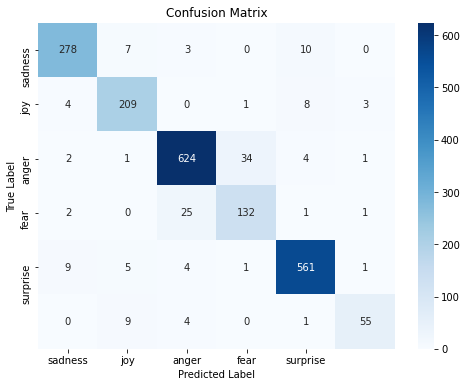

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# After the validation phase, where you have already obtained the predicted and true labels:
# Store the predicted labels and actual labels
all_predictions = []
all_true_labels = []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Get the predicted class
    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    # Append predictions and true labels
    all_predictions.extend(pred_flat)
    all_true_labels.extend(labels_flat)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2int.keys(), yticklabels=label2int.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
!pip install --upgrade transformers


In [ ]:
from transformers import AutoTokenizer, AutoModelForConditionalGeneration

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelForConditionalGeneration.from_pretrained("mrm8488/t5-base-finetuned-emotion")

# Function to predict emotion
def get_emotion(text):
    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')  # Encode the input text
    output = model.generate(input_ids=input_ids, max_length=2)  # Generate prediction
    dec = [tokenizer.decode(ids) for ids in output]  # Decode the output to get the emotion
    label = dec[0]
    return label

# Test the function with examples
print(get_emotion("i feel as if i haven't blogged in ages are at least truly blogged i am doing an update cute"))
print(get_emotion("i have a feeling i kinda lost my best friend"))
